In [10]:
from preprocess import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import seaborn as sns
from preprocess import preprocessing
from preparation import preparation

In [11]:
def printConfussionMatrix(y_test, y_pred):
    sns.heatmap((confusion_matrix(y_test,y_pred)), annot=True, fmt="d",cmap="crest")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

def build_word_frequency_histogram(preprocessed_str):
    wordfreq = {}
    for word in preprocessed_str.split():
        if word not in wordfreq:
            wordfreq[word] = 0
        wordfreq[word] += 1
    return wordfreq

In [12]:
dictPlag = {}
#actual_results = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
actual_results = [1,1,0,0,1,1,0,0,0,0,0,0,0,0,1]
system_results = []

def decision(filePathOriginals, filePathSuspicious):
   
    # Preprocessing original texts
    original_texts = [file for file in os.listdir(filePathOriginals) if os.path.isfile(os.path.join(filePathOriginals, file))]
    processed_original_texts = []
    print(original_texts)
    for original_text in original_texts:
        print(original_text)
        processed_original_texts.append(preprocessing(filePathOriginals + "/" + original_text))
    print(original_texts)

    print("Starting plagiarism detection...")
    print("\n")
    # Preprocessing suspicious texts
    suspicious_texts = [file for file in os.listdir("suspicious_files") if os.path.isfile(os.path.join("suspicious_files", file))]
    processed_suspicious_texts = []
    print(suspicious_texts)
    for suspicious_text in suspicious_texts:
        processed_suspicious_texts.append(preprocessing("suspicious_files/" + suspicious_text))
   
    
    print("len processed suspicious: ", len(processed_original_texts))
    #histograms = []
    
    maxplagiarism = [0 for _ in range(len(processed_suspicious_texts))]
    maxhistograms = [{} for _ in range(len(processed_suspicious_texts))]
    
    # Comparing suspicious text with original texts
    for k, processed_suspicious_text in enumerate(processed_suspicious_texts):
        print("Suspicious text: ", suspicious_text)
        plagiarized_check = False
        for i, processed_original_text in enumerate(processed_original_texts):
            unigram_result, trigram_result = preparation(processed_suspicious_text, processed_original_text)

            # If similarity is greater than 0.5 in unigrams and more , then plagiarism is detected
            if unigram_result > 0.3 and trigram_result > 0.1:
                print("Plagiarism detected in file: ", original_texts[i])
                print("⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️")
                print("\n")
                
                if dictPlag.get(suspicious_text) is None:
                    dictPlag[suspicious_text] = [[original_texts[i],unigram_result,trigram_result]]
                else:
                    dictPlag[suspicious_text].append([original_texts[i], unigram_result,trigram_result])
                    
                
                if not plagiarized_check:
                    system_results.append(1)
                    plagiarized_check = True
            
                # similarities = find_similarities(suspicious_text, original_texts[i])
                # all_similarities.append([original_texts[i], similarities])
                # for similarity, position in similarities:
                #     print(f"Similarity: '{similarity}', Position: {position}")\

                if maxplagiarism[k] <= unigram_result:
                    maxplagiarism[k] = unigram_result
                    maxhistograms[k] = build_word_frequency_histogram(processed_suspicious_text)
                    
                 

                #histograms.append(build_word_frequency_histogram(processed_suspicious_text))
                # categories = list(histogram.keys())[:20]
                # frequencies = list(histogram.values())[:20]
                
                # plt.bar(categories, frequencies)            
                # plt.xlabel('Categories')
                # plt.ylabel('Frequency')
                # plt.title('Category Frequency Histogram')
                # plt.xticks(rotation=90)

        if not plagiarized_check:
            # When there is no plagiarism, append 0 to system results
            system_results.append(0)

    # print(dictPlag)

    maxhistograms = [histogram for histogram in maxhistograms if histogram]

    # Create subplots for all bar charts of histograms
    fig, axs = plt.subplots(len(maxhistograms)+1, figsize=(10, 70))
    fig.tight_layout(pad=10)
    for i, histogram in enumerate(maxhistograms):
        categories = list(histogram.keys())[:20]
        frequencies = list(histogram.values())[:20]
        axs[i].bar(categories, frequencies)            
        axs[i].set_xlabel('Categories')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title('Category Frequency Histogram')
        axs[i].tick_params(axis='x', rotation=90)


    
    print(f'SYS {system_results}')
    print(f'Actual {actual_results}')
    fpr, tpr, thresholds = metrics.roc_curve(actual_results, system_results, pos_label=1)


    # RECORDAR ARREGLAR LO DEL ROOOOC

    print("False Positive Rate: ", fpr)
    print("True Positive Rate: ", tpr)
    print("AUC:", metrics.auc(fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.title('ROC curve')
    plt.xlabel("Error")
    plt.ylabel("True Positive Rate")
    plt.show()
    printConfussionMatrix(actual_results, system_results)


['org-001.txt', 'org-002.txt', 'org-003.txt', 'org-004.txt', 'org-005.txt', 'org-006.txt', 'org-007.txt', 'org-008.txt', 'org-009.txt', 'org-010.txt', 'org-011.txt', 'org-012.txt', 'org-013.txt', 'org-014.txt', 'org-015.txt', 'org-016.txt', 'org-017.txt', 'org-018.txt', 'org-019.txt', 'org-020.txt', 'org-021.txt', 'org-022.txt', 'org-023.txt', 'org-024.txt', 'org-025.txt', 'org-026.txt', 'org-027.txt', 'org-028.txt', 'org-029.txt', 'org-030.txt', 'org-031.txt', 'org-032.txt', 'org-033.txt', 'org-034.txt', 'org-035.txt', 'org-036.txt', 'org-037.txt', 'org-038.txt', 'org-039.txt', 'org-040.txt', 'org-041.txt', 'org-042.txt', 'org-043.txt', 'org-044.txt', 'org-045.txt', 'org-046.txt', 'org-047.txt', 'org-048.txt', 'org-049.txt', 'org-050.txt', 'org-051.txt', 'org-052.txt', 'org-053.txt', 'org-054.txt', 'org-055.txt', 'org-056.txt', 'org-057.txt', 'org-058.txt', 'org-059.txt', 'org-060.txt', 'org-061.txt', 'org-062.txt', 'org-063.txt', 'org-064.txt', 'org-065.txt', 'org-066.txt', 'org-067.

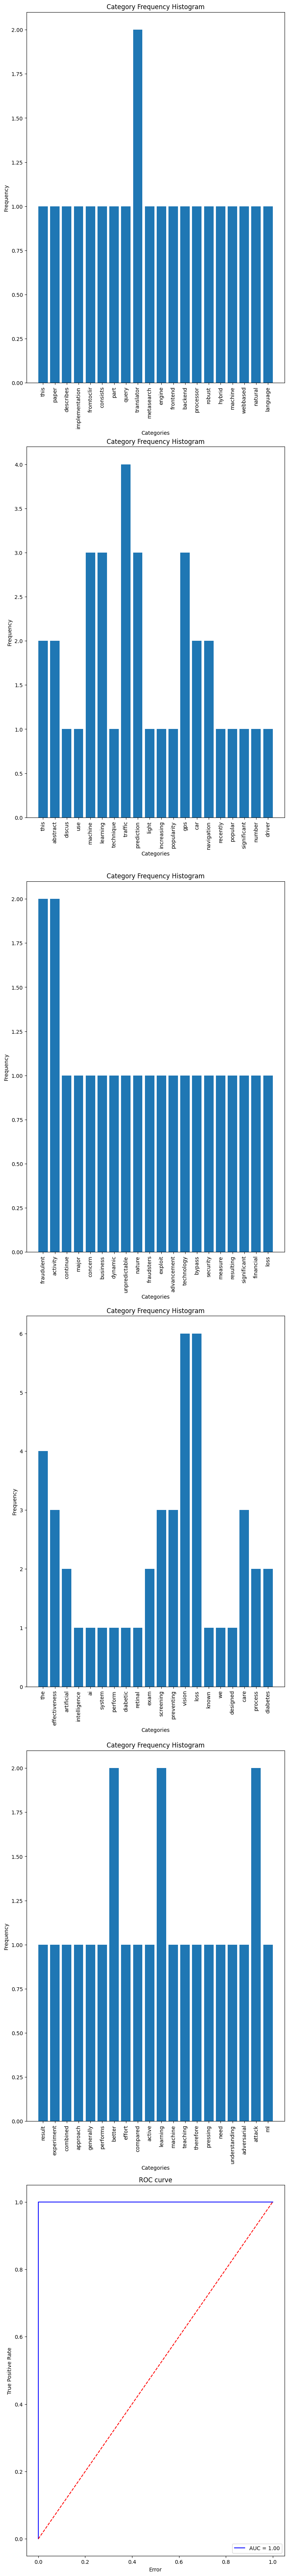

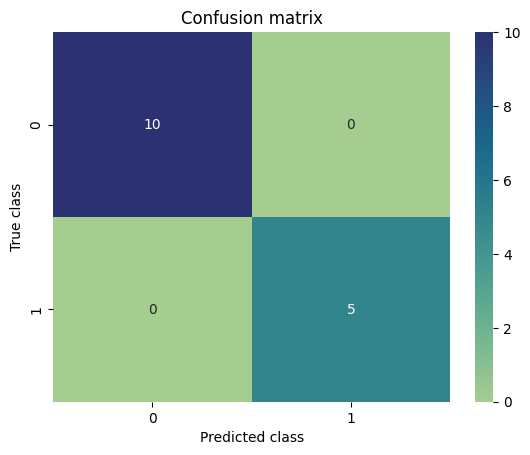

In [13]:
decision("original_files", "suspicious_files")